## 2 constrasts model

This notebook load, preprocess the data and train a first modèle to predict if a 2 image is T1w or T2w.
The Notebook form helps running and testing fast before coding the final structure

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import nibabel as nib
import pandas as pd
from monai.data import Dataset, DataLoader, CacheDataset
import torchvision.models as models
from monai.transforms import (
    Compose,
    RandScaleCrop,
    RandFlip,
    RandRotate90,
    RandRotate,
    RandShiftIntensity,
    ToTensor,
    RandSpatialCrop,
    LoadImage,
    SqueezeDim,
    RandRotate,
)
import os
from sklearn.model_selection import train_test_split
import monai




device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# this cell aims at extracting the list of path relevant for the first model test which takes T1w T2w adn DWI as image

base_dir="data//data-multi-subject//"

desired_extension = ".json"

# Initialize lists to store the relative paths for T1w, T2w, and DWI files
t1w_file_paths = []
t2w_file_paths = []

print("Searching for T1w, T2w, and DWI files in", base_dir, "...")

# Traverse the directory structure
for root, dirs, files in os.walk(base_dir):
    # Exclude the "derivatives" subfolder
    if "derivatives" in dirs:
        dirs.remove("derivatives")
    for file in files:
        # Check if the file name contains the desired names
        if "T1w" in file and file.endswith(desired_extension):
            # Get the relative path of the T1w file
            relative_path = os.path.relpath(os.path.join(root, file), base_dir)
            # Remove the file extension
            relative_path = os.path.splitext(base_dir + relative_path)[0] + ".nii.gz"
            # Append the relative path to the T1w file paths list
            t1w_file_paths.append(relative_path)
        elif "T2w" in file and file.endswith(desired_extension):
            # Get the relative path of the T2w file
            relative_path = os.path.relpath(os.path.join(root, file), base_dir)
            # Remove the file extension
            relative_path = os.path.splitext(relative_path)[0] + ".nii.gz"
            # Append the relative path to the T2w file paths list
            t2w_file_paths.append(base_dir + relative_path)

#t1w_file_paths = t1w_file_paths[:20]
#t2w_file_paths = t2w_file_paths[:20]

print("Found", len(t1w_file_paths), "T1w files and", len(t2w_file_paths), "T2w files.")

Searching for T1w, T2w, and DWI files in data//data-multi-subject// ...
Found 267 T1w files and 267 T2w files.


In [3]:
# split the data into training and validation sets

# build a dataset with a colmn "file path" wich contiains the paths listed in both t1w_file_paths and t2w_file_paths
path_data = pd.DataFrame({"image_path" : t1w_file_paths + t2w_file_paths, "labels" : len(t1w_file_paths) * [0] + len(t2w_file_paths) * [1]})

train_data, val_data = train_test_split(path_data, test_size=0.2, random_state=0)
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)



In [12]:
# Define a custom dataset class
class Dataset_2D(Dataset):
    def __init__(self, paths, labels, transform=None):
        self.data = {"paths" : paths, "labels" : labels}
        self.transform = transform
        self.length = len(self.data["paths"])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        path = self.data["paths"][index]
        label = [0,1] if self.data["labels"][index] else [1,0]
        if self.transform:
            image = self.transform(path)
            dim_to_squeeze = int(np.random.choice([0,1,2]))
            roi_min = np.array([30, 30, 30])
            roi_max = np.array([-1, -1, -1])
            roi_min[dim_to_squeeze] = 1
            roi_max[dim_to_squeeze] = 1
            image = RandSpatialCrop(roi_min,  max_roi_size = roi_max, random_size=True, random_center=True)(image)
            image = SqueezeDim(dim=dim_to_squeeze + 1)(image)
            # Convert to tensor
            image = ToTensor()(image)
            # add a dimension to the image, for exemple [1, 256, 256] -> [1, 1, 256, 256]
            image = image.unsqueeze(0)

        # convert label list to tensor with shape [1,2]
        label = torch.tensor([label])
        return image, label
    
# use monai to define the transforms for data augmentation
# perform the following transformations : rotation (random between +3° and -3°), flipping (random between 0°,  90 °, 180° and 270°), cropping (Random size, random place) and shifting (random shift)

train_transforms = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
        RandRotate90(prob=0.5),
        RandFlip(prob=0.5),
        RandShiftIntensity(offsets=0.1, prob=0.5),
        RandRotate(range_x=3, range_y=3, range_z=3, prob=0.2),
        
    ]
)

val_transforms = Compose(
    [
        LoadImage(image_only=True, ensure_channel_first=True),
    ]
)

# Create the custom datasets
train_dataset = Dataset_2D(
    paths=train_data['image_path'],
    labels=train_data['labels'],
    transform=train_transforms,
)

val_dataset = Dataset_2D(
    paths=val_data['image_path'],
    labels=val_data['labels'],
    transform=val_transforms,
)


Index: 397
torch.Size([1, 1, 223, 111]) tensor([[1, 0]])


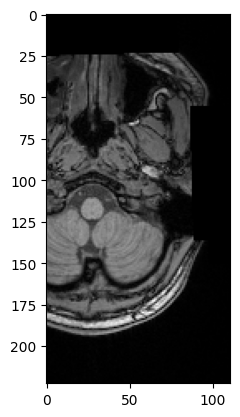

In [13]:
# get an image
i = np.random.randint(0, train_dataset.length)
print("Index:", i)
image, label = train_dataset[i]
print(image.shape, label)

#show image in black and white
import matplotlib.pyplot as plt
plt.imshow(image[0, 0], cmap='gray')
plt.show()




In [14]:
class ResNet18SingleChannel(nn.Module):
    # Define the ResNet18 model with a single image channel and an output value between 0 and 1
    def __init__(self, num_classes=2):
        super(ResNet18SingleChannel, self).__init__()
        # Load the pre-trained ResNet18 model
        resnet = models.resnet18(pretrained=False)
        # Modify the first convolutional layer to take a single channel input
        resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)
        # Modify the final fully connected layer to output a single value

        self.resnet = resnet

        #final fc to go from [batch_size, 1000] to [batch_size, num_classes]
        self.fc = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.resnet(x)
        x = self.fc(x)
        x = torch.sigmoid(x)
        return x

model = ResNet18SingleChannel(num_classes=2).to(device)

image, label = train_dataset[0]
print(image)
output = model.forward(image.to(device))
print(output)

c:\Users\bapti\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\bapti\AppData\Local\Programs\Python\Python310\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


metatensor([[[[ 1.,  0.,  1.,  ...,  4.,  3.,  6.],
          [ 1.,  1.,  1.,  ...,  3.,  4.,  5.],
          [ 2.,  2.,  1.,  ...,  2.,  4.,  2.],
          ...,
          [ 0.,  1.,  0.,  ..., 19., 25., 24.],
          [ 1.,  2.,  2.,  ..., 21., 19., 15.],
          [ 1.,  2.,  2.,  ..., 10., 16., 20.]]]])
metatensor([[0.4944, 0.6077]], grad_fn=<AliasBackward0>)


In [18]:
from monai.losses import DiceLoss
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
optimizer = optim.Adam(model.parameters(), lr=0.001)


# Define the training loop
def training_one_epoch(model):
    model.train()
    running_loss = 0.0
    queue_line = np.arange(train_dataset.length)
    np.random.shuffle(queue_line) 
    index=0
    for i in queue_line:
        if index%200 == 0:
            print(index)
        image, label = train_dataset[i]
        image, label = image.to(device), label.to(device)
        print(image.shape)
        print(label.shape)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, label.float())
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        index+=1
    return model, running_loss / len(train_dataset)

# Define the number of epochs
num_epochs = 100

for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1} / {num_epochs}")
    model, train_loss = training_one_epoch(model)
    print(f"Epoch {epoch + 1} training loss: {train_loss}")
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"model_{epoch + 1}.pth")
#save model
torch.save(model.state_dict(), "model.pth")



Epoch 1 / 100
0
torch.Size([1, 1, 91, 33])
torch.Size([1, 2])
torch.Size([1, 1, 126, 274])
torch.Size([1, 2])
torch.Size([1, 1, 271, 54])
torch.Size([1, 2])
torch.Size([1, 1, 48, 226])
torch.Size([1, 2])
torch.Size([1, 1, 92, 192])
torch.Size([1, 2])
torch.Size([1, 1, 33, 297])
torch.Size([1, 2])
torch.Size([1, 1, 36, 122])
torch.Size([1, 2])
torch.Size([1, 1, 30, 220])
torch.Size([1, 2])
torch.Size([1, 1, 108, 255])
torch.Size([1, 2])


KeyboardInterrupt: 

In [ ]:
# Assess the model accuracy on the validation set

def evaluate_model(model, dataset):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(dataset.length):
            image, label = dataset[i]
            image, label = image.to(device), label.to(device)
            outputs = model(image)
            predicted = torch.argmax(outputs)
            if i % 2 == 0:
                print(outputs)
            total += label.size(0)
            correct += (predicted == torch.argmax(label)).sum().item()
    return correct / total

accuracy = evaluate_model(model, val_dataset)
print(f"Validation accuracy: {accuracy}")

metatensor([[0.6818, 0.3297]])
metatensor([[0.6832, 0.3287]])
metatensor([[0.0154, 0.9768]])
metatensor([[0.6825, 0.3292]])


c:\Users\bapti\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\transforms\utility\array.py:597: UserWarning: After SqueezeDim, img.affine is ill-posed: 
tensor([[ 0.0000e+00,  4.3468e-02,  9.9905e-01, -5.6091e+01],
        [-1.0002e+00,  0.0000e+00,  0.0000e+00,  9.5959e+01],
        [ 0.0000e+00,  9.9928e-01, -4.3459e-02,  2.9378e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64).
  warnings.warn(f"After SqueezeDim, img.affine is ill-posed: \n{img.affine}.")


metatensor([[0.6833, 0.3286]])
metatensor([[0.6825, 0.3292]])
metatensor([[0.6835, 0.3283]])
metatensor([[0.6839, 0.3280]])


c:\Users\bapti\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\transforms\utility\array.py:597: UserWarning: After SqueezeDim, img.affine is ill-posed: 
tensor([[ 0.0000e+00,  2.2680e-02,  7.9968e-01, -2.6430e+01],
        [-8.0000e-01,  0.0000e+00,  0.0000e+00, -4.8012e+01],
        [ 0.0000e+00,  7.9968e-01, -2.2680e-02, -8.5927e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64).
  warnings.warn(f"After SqueezeDim, img.affine is ill-posed: \n{img.affine}.")


metatensor([[0.6819, 0.3295]])
metatensor([[0.6829, 0.3290]])
metatensor([[0.6838, 0.3280]])
metatensor([[0.6838, 0.3280]])
metatensor([[0.6836, 0.3282]])
metatensor([[0.6829, 0.3290]])
metatensor([[0.6839, 0.3279]])
metatensor([[0.6832, 0.3287]])
metatensor([[0.6836, 0.3283]])
metatensor([[0.6836, 0.3282]])
metatensor([[0.6833, 0.3286]])
metatensor([[0.6839, 0.3279]])
metatensor([[0.6838, 0.3281]])
metatensor([[0.6826, 0.3290]])
metatensor([[0.6819, 0.3296]])
metatensor([[0.6831, 0.3287]])
metatensor([[0.6814, 0.3304]])
metatensor([[0.6832, 0.3286]])
metatensor([[0.6838, 0.3280]])
metatensor([[0.6833, 0.3285]])
metatensor([[0.6842, 0.3277]])
metatensor([[0.0055, 0.9951]])
metatensor([[0.6838, 0.3280]])
metatensor([[0.6840, 0.3279]])
metatensor([[0.6839, 0.3279]])
metatensor([[0.6837, 0.3281]])
metatensor([[0.6839, 0.3279]])
metatensor([[0.6841, 0.3278]])
metatensor([[0.6839, 0.3279]])
metatensor([[0.6814, 0.3305]])
metatensor([[0.6826, 0.3290]])
metatensor([[0.6829, 0.3290]])
metatens

c:\Users\bapti\AppData\Local\Programs\Python\Python310\lib\site-packages\monai\transforms\utility\array.py:597: UserWarning: After SqueezeDim, img.affine is ill-posed: 
tensor([[ 0.0000e+00,  2.8356e-02,  9.9960e-01,  7.6665e+00],
        [-1.0002e+00,  0.0000e+00,  0.0000e+00, -4.6280e+01],
        [ 0.0000e+00,  9.9982e-01, -2.8350e-02,  4.6102e+01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]],
       dtype=torch.float64).
  warnings.warn(f"After SqueezeDim, img.affine is ill-posed: \n{img.affine}.")


metatensor([[0.6829, 0.3288]])
metatensor([[0.6831, 0.3287]])
metatensor([[0.6829, 0.3290]])
metatensor([[0.6833, 0.3286]])
metatensor([[0.6831, 0.3287]])
metatensor([[0.6841, 0.3278]])
metatensor([[0.6828, 0.3291]])
metatensor([[0.6830, 0.3288]])
Validation accuracy: 0.4953271028037383
